In [29]:
from torchvision.datasets import Cityscapes
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import torchvision.transforms as T
from torchvision.transforms import functional as F


from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [30]:
dataset = Cityscapes(
    root='../input/cityscape-semantic-dataset/data',
    split='train',
    mode='fine',
    target_type='semantic'
)

print("Done")

Done


## EDA- Check

In [31]:
dataset[0][0].size

(2048, 1024)

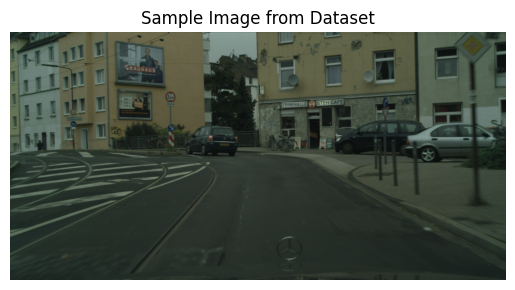

In [32]:
import matplotlib.pyplot as plt

img, _ = dataset[0]

plt.imshow(img)
plt.title("Sample Image from Dataset")
plt.axis("off")
plt.show()

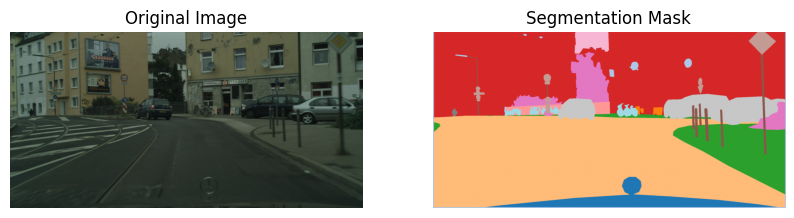

In [33]:
img, mask = dataset[0]

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(mask, cmap="tab20")
plt.title("Segmentation Mask")
plt.axis("off")

plt.show()

### Create a wrapped dataset

In [34]:
class CityscapesTrainDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, img_transform, mask_transform):
        self.base = base_dataset
        self.img_tf = img_transform
        self.mask_tf = mask_transform

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        img, mask = self.base[idx]

        img = self.img_tf(img)

        mask = self.mask_tf(mask).squeeze(0)

        new_mask = torch.full_like(mask, 255)
        for old_id, new_id in CITYSCAPES_ID_MAP.items():
            new_mask[mask == old_id] = new_id

        return img, new_mask.long()

In [35]:
img_transform = T.Compose([
    T.Resize((256, 512)),                 # keep consistent size
    T.ToTensor(),                         # [0,1]
    T.Normalize(
        mean=[0.485, 0.456, 0.406],       # ImageNet stats
        std=[0.229, 0.224, 0.225]
    )
])


**Image Transformation**

To prepare the input images for training, a sequence of image transformations was applied. Each RGB image was resized to a fixed spatial resolution to ensure consistent tensor dimensions across batches. The images were then converted to tensors with values scaled to the range [0, 1]. Finally, the images were normalized using the mean and standard deviation values of the ImageNet dataset. This normalization step improves numerical stability during training and aligns the input distribution with the statistics expected by the ResNet-50 backbone used in the segmentation model.

In [36]:
def mask_transform(mask):
    mask = F.resize(mask, (256, 512), interpolation=F.InterpolationMode.NEAREST)
    mask = torch.as_tensor(np.array(mask), dtype=torch.long)
    return mask


**Segmentation Mask Transformation**

Segmentation masks require a different preprocessing strategy than input images. Each mask was resized to the same spatial resolution as the corresponding input image using nearest-neighbor interpolation in order to preserve discrete class labels. The mask was then converted into a tensor of integer values representing class indices. No normalization was applied to the masks, as the loss function expects raw class IDs for correct pixel-wise classification.

In [37]:
train_ds = CityscapesTrainDataset(
    dataset,
    img_transform,
    mask_transform
)

loader = DataLoader(
    train_ds,          
    batch_size=4,
    shuffle=True,
    num_workers=2
)


criterion = nn.CrossEntropyLoss(ignore_index=255)

print("Done")

Done


## Resizing

In [38]:
img_transform = transforms.Compose([
    transforms.Resize((256, 512)),
    transforms.ToTensor(),
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 512), interpolation=Image.NEAREST),
    transforms.PILToTensor(),   
])


img, mask = dataset[0]

img_t = img_transform(img)
mask_t = mask_transform(mask)


print("Image min/max:", img_t.min().item(), img_t.max().item())


print("Mask unique values:", torch.unique(mask_t))

Image min/max: 0.03921568766236305 0.7607843279838562
Mask unique values: tensor([ 1,  3,  4,  5,  6,  7,  8, 11, 13, 17, 20, 21, 23, 24, 26, 33],
       dtype=torch.uint8)


## Relabeling

In [39]:
CITYSCAPES_ID_MAP = {
     7: 0,   # road
     8: 1,   # sidewalk
    11: 2,   # building
    12: 3,   # wall
    13: 4,   # fence
    17: 5,   # pole
    19: 6,   # traffic light
    20: 7,   # traffic sign
    21: 8,   # vegetation
    22: 9,   # terrain
    23: 10,  # sky
    24: 11,  # person
    25: 12,  # rider
    26: 13,  # car
    27: 14,  # truck
    28: 15,  # bus
    31: 16,  # train
    32: 17,  # motorcycle
    33: 18   # bicycle
}

In [40]:
#mask = transforms.PILToTensor()(mask).squeeze(0)  

#RUN ONLY ONCE 

In [41]:
new_mask = torch.full_like(mask, 255)

for old_id, new_id in CITYSCAPES_ID_MAP.items():
    new_mask[mask == old_id] = new_id

mask = new_mask.long()

torch.unique(mask).tolist()

[0, 1, 2, 4, 5, 7, 8, 10, 11, 13, 18, 255]

### Why Some Class IDs Are Missing (e.g., 3, 6, 9)

Cityscapes defines **19 possible classes** (0–18), but **each image only contains a subset of them**.

In this image:
- Classes `3`, `6`, `9`, etc. **do not appear**
- Therefore, they are **absent from `torch.unique(mask)`**

This is normal and expected.

**Important:**
- Missing class IDs ≠ missing from the dataset
- The model must still output **all 19 classes**
- Other images will contain the missing classes

**Conclusion:**  
The mask is correct; the missing numbers simply mean those objects are not present in this scene.

**Simple plot to check**

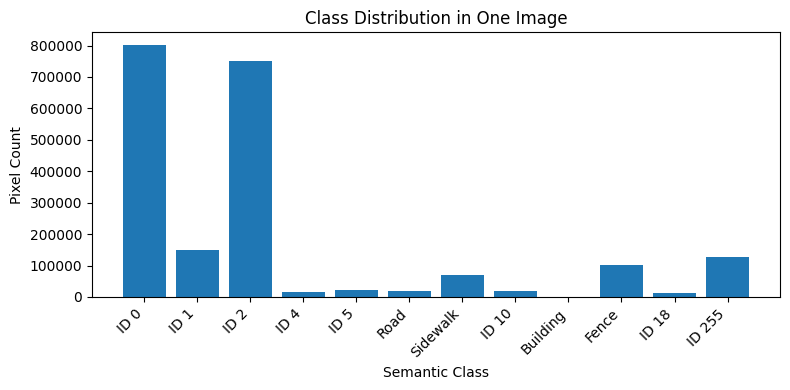

In [42]:
CLASS_NAMES = {
    7: "Road",
    8: "Sidewalk",
    11: "Building",
    12: "Wall",
    13: "Fence",
    17: "Pole",
    19: "Traffic Light",
    20: "Traffic Sign",
    21: "Vegetation",
    22: "Terrain",
    23: "Sky",
    24: "Person",
    25: "Rider",
    26: "Car",
    27: "Truck",
    28: "Bus",
    31: "Train",
    32: "Motorcycle",
    33: "Bicycle"
}


mask_np = np.array(mask)
values, counts = np.unique(mask_np, return_counts=True)

labels = [CLASS_NAMES.get(v, f"ID {v}") for v in values]

plt.figure(figsize=(8,4))
plt.bar(labels, counts)
plt.xlabel("Semantic Class")
plt.ylabel("Pixel Count")
plt.title("Class Distribution in One Image")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

**Class IDs 1–6 correspond to non-semantic or void regions defined by the Cityscapes annotation protocol and are excluded from training and evaluation.**

## 1st Model: FCN-ResNet50.

In [43]:
from torchvision.models.segmentation import fcn_resnet50
from tqdm import tqdm

# Device FIRST
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Model
model_fcn = fcn_resnet50(num_classes=19)
model_fcn = model_fcn.to(device)

# Optimizer
optimizer = torch.optim.Adam(model_fcn.parameters(), lr=1e-4)

# Training loop
model_fcn.train()

num_epochs = 5

for epoch in range(num_epochs):
    total_loss = 0.0

    progress_bar = tqdm(loader, desc=f"Epoch {epoch + 1}/{num_epochs}", leave=False)

    for imgs, masks in progress_bar:
        imgs = imgs.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()

        outputs = model_fcn(imgs)["out"]   # [B, C, H, W]
        loss = criterion(outputs, masks)   # masks: [B, H, W]

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    avg_loss = total_loss / len(loader)
    print(f"Epoch {epoch + 1}: Avg Loss = {avg_loss:.4f}")


Using device: cuda
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 194MB/s] 


Epoch 1: Avg Loss = 0.3883


Epoch 2: Avg Loss = 0.2510


Epoch 3: Avg Loss = 0.2084


Epoch 4: Avg Loss = 0.1936


Epoch 5: Avg Loss = 0.1727


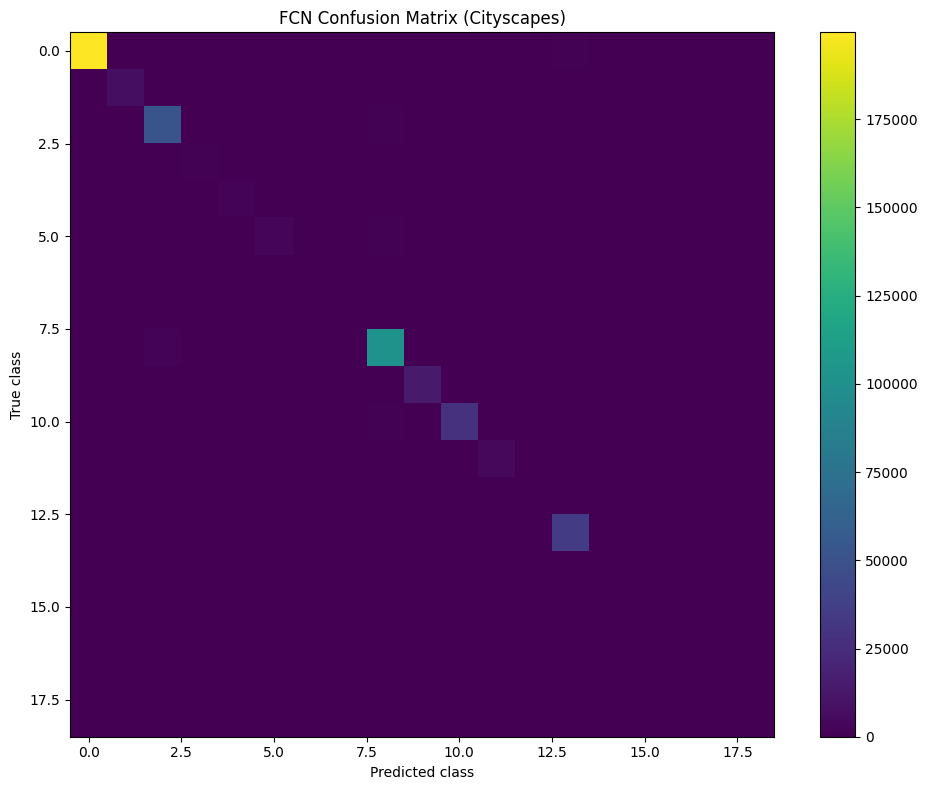

In [50]:
model_fcn.eval()

imgs, masks = next(iter(loader))
imgs = imgs.to(device)
masks = masks.to(device)

with torch.no_grad():
    outputs = model_fcn(imgs)["out"]
    preds = torch.argmax(outputs, dim=1)

preds = preds.view(-1)
masks = masks.view(-1)

valid = masks != 255
preds = preds[valid]
masks = masks[valid]

preds = preds.cpu()
masks = masks.cpu()

cm_fcn = torch.zeros(19, 19, dtype=torch.int64)

for t, p in zip(masks, preds):
    cm_fcn[t, p] += 1

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.imshow(cm_fcn, interpolation="nearest")
plt.colorbar()

plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.title("FCN Confusion Matrix (Cityscapes)")

plt.tight_layout()
plt.show()

### 2nd Model: DeepLabV3-ResNet50

In [51]:
from torchvision.models.segmentation import deeplabv3_resnet50
model = deeplabv3_resnet50(num_classes=19)

In [46]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

model.train()

for epoch in range(5):
    total_loss = 0.0

    progress_bar = tqdm(loader, desc=f"Epoch {epoch + 1}", leave=False)

    for imgs, masks in progress_bar:
        imgs = imgs.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()

        outputs = model(imgs)["out"]
        loss = criterion(outputs, masks)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        progress_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(loader)
    print(f"Epoch {epoch + 1}: Avg Loss = {avg_loss:.4f}")

Epoch 1: Avg Loss = 0.4914


Epoch 2: Avg Loss = 0.2840


Epoch 3: Avg Loss = 0.2368


Epoch 4: Avg Loss = 0.2064


Epoch 5: Avg Loss = 0.1916


In [54]:
import torch
from torchvision.models.segmentation import deeplabv3_resnet50

# Define device ONCE, as a torch.device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Recreate + move model (guarantees weights are on GPU if available)
model = deeplabv3_resnet50(num_classes=19).to(device)
model.eval()

# Sanity check: confirm model really moved
print("Model params device:", next(model.parameters()).device)


Using device: cuda
Model params device: cuda:0


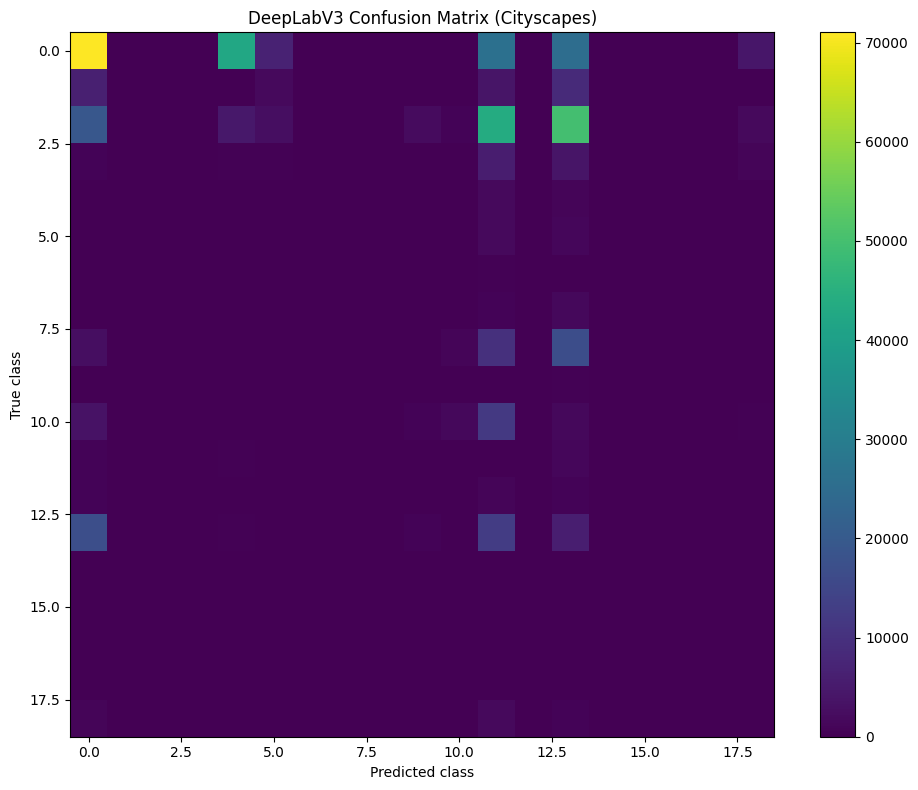

In [55]:
model.eval()

imgs, masks = next(iter(loader))
imgs = imgs.to(device)
masks = masks.to(device)

with torch.no_grad():
    outputs = model(imgs)["out"]
    preds = outputs.argmax(dim=1)

preds = preds.view(-1)
masks = masks.view(-1)

valid = masks != 255
preds = preds[valid].cpu()
masks = masks[valid].cpu()

cm_dl = torch.zeros(19, 19, dtype=torch.int64)

for t, p in zip(masks, preds):
    cm_dl[t, p] += 1

plt.figure(figsize=(10, 8))
plt.imshow(cm_dl, interpolation="nearest")
plt.colorbar()
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.title("DeepLabV3 Confusion Matrix (Cityscapes)")
plt.tight_layout()
plt.show()


### Comparissons

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8610327..1.9602616].


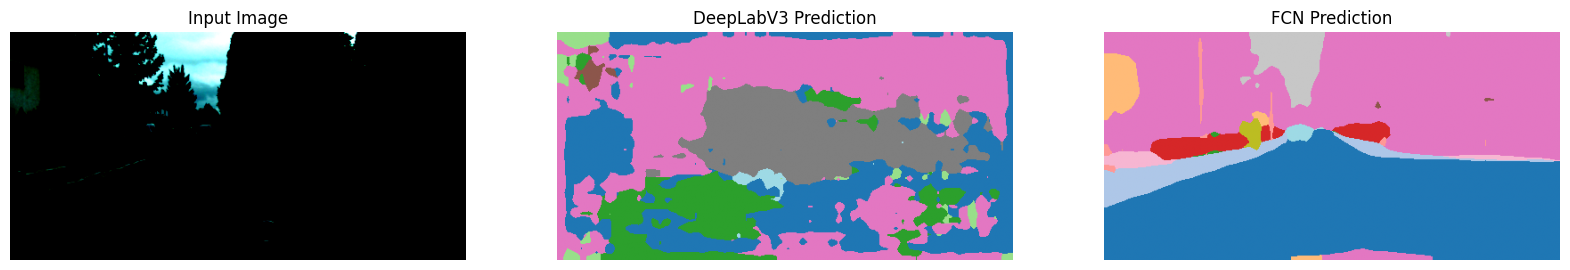

In [56]:
import matplotlib.pyplot as plt

imgs_vis, masks_vis = next(iter(loader))

imgs_vis = imgs_vis.to(device)
masks_vis = masks_vis.to(device)

model.eval()
model_fcn.eval()

with torch.no_grad():
    pred_dl = torch.argmax(model(imgs_vis)["out"], dim=1)
    pred_fcn = torch.argmax(model_fcn(imgs_vis)["out"], dim=1)

i = 0

img = imgs_vis[i].cpu().permute(1, 2, 0)   
dl  = pred_dl[i].cpu()                    
fcn = pred_fcn[i].cpu()                   


plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Input Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(dl, cmap="tab20")
plt.title("DeepLabV3 Prediction")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(fcn, cmap="tab20")
plt.title("FCN Prediction")
plt.axis("off")

plt.show()

In [57]:
def mean_iou(cm):
    intersection = cm.diag()
    union = cm.sum(1) + cm.sum(0) - cm.diag()
    iou = intersection / union.clamp(min=1)
    return iou.mean().item(), iou

miou_dl, iou_dl = mean_iou(cm_dl)
miou_fcn, iou_fcn = mean_iou(cm_fcn)

print("DeepLab mIoU:", round(miou_dl, 4))
print("FCN mIoU:", round(miou_fcn, 4))

DeepLab mIoU: 0.0223
FCN mIoU: 0.5472
